## Задание

1. **Реализация разделенной стратегии:**
   - Реализуйте алгоритм управления МК с разделенной стратегией для среды `Acrobot` из библиотеки OpenAI Gym.
   - Используйте случайную поведенческую стратегию для сбора данных и обучения целевой стратегии.

2. **Оптимизация параметров:**
   - Проведите эксперименты с различными значениями параметров (например, коэффициент обесценивания `gamma`, количество эпизодов `n_episode`, ε для ε-жадной стратегии).
   - Определите оптимальные значения параметров, которые приводят к наилучшим результатам в обучении.

3. **Сравнение стратегий:**
   - Сравните оптимальную стратегию, полученную с использованием разделенной стратегии, с оптимальной стратегией, полученной с использованием ε-жадной стратегии.
   - Проанализируйте, какая стратегия дает лучшие результаты в среде `Acrobot`.

4. **Визуализация результатов:**
   - Визуализируйте Q-функцию и стратегию для среды `Acrobot`.
   - Используйте библиотеку `matplotlib` для построения графиков и поверхностей, чтобы наглядно представить результаты.

In [1]:
#@title Установка зависимостей
!pip install --upgrade gymnasium numpy matplotlib torch > /dev/null 2>&1

In [2]:
#@title Импорты
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import time
from functools import lru_cache
from typing import Tuple, List, Dict, Callable

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Совместимость gym numpy
np.bool8 = np.bool_

In [3]:
#@title Константы
ENV_NAME = "Acrobot-v1"
# Параметры дискретизации для Acrobot (6-мерное пространство состояний)
# Углы: 8x8, Угловые скорости: 4x4x4x4
STATE_BINS = (8, 8, 4, 4, 4, 4)
N_BINS = len(STATE_BINS)

# Создание и инициализация среды
env = gym.make(ENV_NAME)
N_ACTION = env.action_space.n

In [4]:
#@title Функции дискретизации и утилиты

def create_state_bounds(env: gym.Env, state_bins: Tuple[int, ...]) -> List[np.ndarray]:
    """
    Создает границы для дискретизации каждого измерения пространства состояний.
    """
    bounds = []
    for i, bins in enumerate(state_bins):
        low = env.observation_space.low[i]
        high = env.observation_space.high[i]

        # Для Acrobot некоторые измерения не имеют конечных границ
        # Используем стандартные значения для углов и угловых скоростей
        if not np.isfinite(low) or not np.isfinite(high):
            if i >= 4:  # Угловые скорости (последние 4 измерения)
                low, high = -12.0, 12.0
            else:  # Углы (первые 2 измерения)
                low, high = -1.0, 1.0

        b = np.linspace(low, high, bins + 1)
        bounds.append(b)
    return bounds


STATE_BOUNDS = create_state_bounds(env, STATE_BINS)


@lru_cache(maxsize=300_000)
def discretize_state_cached(state_tuple: Tuple[float, ...]) -> Tuple[int, ...]:
    """
    Кэшированная дискретизация состояния.
    """
    state = np.array(state_tuple)
    discrete = []
    for i in range(N_BINS):
        idx = np.digitize(state[i], STATE_BOUNDS[i]) - 1
        idx = int(np.clip(idx, 0, STATE_BINS[i] - 1))
        discrete.append(idx)
    return tuple(discrete)


def discretize_state(state: np.ndarray) -> Tuple[int, ...]:
    """
    Преобразует непрерывное состояние в дискретное.
    """
    return discretize_state_cached(tuple(np.round(state, 5)))

In [5]:
#@title Оценка политики
def evaluate_policy(env: gym.Env, policy: Dict[Tuple[int, ...], int],
                    n_eval_episode: int = 200) -> float:
    """
    Оценивает среднюю суммарную награду политики за заданное количество эпизодов.
    """
    total_rewards = []
    for _ in range(n_eval_episode):
        state, _ = env.reset()
        d = discretize_state(state)

        ep_reward = 0.0
        while True:
            # Выбираем действие из политики или случайное, если состояние не посещалось
            action = policy.get(d, env.action_space.sample())
            state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            d = discretize_state(state)
            if terminated or truncated:
                break
        total_rewards.append(ep_reward)

    return float(np.mean(total_rewards))

In [6]:
#@title Политики поведения и запуск эпизодов

def gen_random_policy(n_action: int):
    """
    Генерирует случайную поведенческую политику μ с равновероятным выбором действий.
    """
    probs = torch.ones(n_action) / n_action
    return lambda s: probs


def run_episode_off_policy(env, behavior_policy):
    """
    Запускает один эпизод с заданной поведенческой стратегией для off-policy обучения.
    """
    state, _ = env.reset()
    d = discretize_state(state)

    states, actions, rewards = [], [], []

    while True:
        probs = behavior_policy(d)
        action = int(torch.multinomial(probs, 1).item())

        states.append(d)
        actions.append(action)

        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        d = discretize_state(state)
        if terminated or truncated:
            break
    return states, actions, rewards


def run_episode_on_policy(env, Q, epsilon: float):
    """
    Запускает один эпизод с ε-жадной стратегией для on-policy обучения.
    """
    state, _ = env.reset()
    d = discretize_state(state)

    states, actions, rewards = [], [], []

    while True:
        if d not in Q:
            Q[d] = torch.zeros(N_ACTION)

        # ε-жадная политика: равномерное распределение с бонусом для лучшего действия
        probs = torch.ones(N_ACTION) * (epsilon / N_ACTION)
        best = int(torch.argmax(Q[d]).item())
        probs[best] += 1.0 - epsilon

        action = int(torch.multinomial(probs, 1).item())

        states.append(d)
        actions.append(action)

        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        d = discretize_state(state)
        if terminated or truncated:
            break

    return states, actions, rewards

In [7]:
#@title MC-control: Off-policy (разделенная стратегия)
def mc_control_off_policy(env, gamma, n_episode, behavior_policy,
                          alpha=None, verbose=True):
    """
    Алгоритм управления методом Монте-Карло с разделенной стратегией (Off-Policy MC Control).
    """

    Q = defaultdict(lambda: torch.zeros(N_ACTION))
    C = defaultdict(lambda: torch.zeros(N_ACTION))  # Накопитель весов для Weighted IS
    returns = []

    for ep in range(1, n_episode + 1):
        # Генерируем эпизод по поведенческой политике μ
        states_d, actions_t, rewards_t = run_episode_off_policy(env, behavior_policy)

        ep_return = sum(rewards_t)
        returns.append(ep_return)

        avg_return_recent = (
            np.mean(returns[-100:]) if len(returns) >= 100 else np.mean(returns)
        )

        G = 0.0  # Накопленный возврат (return)
        W = 1.0  # Importance sampling вес

        # Обрабатываем эпизод с конца для вычисления returns
        for state_d, action_t, reward_t in zip(states_d[::-1], actions_t[::-1], rewards_t[::-1]):
            G = gamma * G + reward_t

            if state_d not in Q:
                Q[state_d] = torch.zeros(N_ACTION)
            if state_d not in C:
                C[state_d] = torch.zeros(N_ACTION)

            # Детерминированно жадная целевая политика π
            best = int(torch.argmax(Q[state_d]).item())
            # Жадная политика: вероятность 1.0 для лучшего действия, 0.0 для остальных
            prob_pi = 1.0 if action_t == best else 0.0
            prob_b = behavior_policy(state_d)[action_t].item()

            # Вычисляем importance sampling ratio
            if prob_b > 0.0:
                rho = prob_pi / prob_b
            else:
                rho = 0.0

            # Weighted Importance Sampling: обновление через накопитель весов
            # Формула: Q(s,a) += (W / C(s,a)) * (G - Q(s,a))
            # где C(s,a) накапливает веса W
            C[state_d][action_t] += W

            # Обновление Q с использованием Weighted IS
            if C[state_d][action_t].item() > 0:
                old_q = Q[state_d][action_t].item()
                # Используем либо полную формулу Weighted IS, либо комбинацию с alpha
                if alpha is not None and alpha > 0:
                    # Комбинированный подход: Weighted IS с шагом alpha
                    Q[state_d][action_t] = old_q + (W / C[state_d][action_t].item()) * alpha * (G - old_q)
                else:
                    # Чистый Weighted IS
                    Q[state_d][action_t] = old_q + (W / C[state_d][action_t].item()) * (G - old_q)

            W *= rho
            # Продолжаем обновление независимо от значения W

        if verbose and ep % (n_episode // 10) == 0:
            print(f"EP {ep}/{n_episode}, avg_return_recent={avg_return_recent:.2f}")

    # Итоговая политика π — жадная по Q
    policy = {s: int(torch.argmax(q)) for s, q in Q.items()}
    return Q, policy, returns

In [8]:
#@title MC-control: On-policy ε-greedy
def mc_control_epsilon_greedy(env, gamma, n_episode, eps_start, eps_final, alpha=0.05, verbose=True):
    """
    Алгоритм управления методом Монте-Карло с ε-жадной стратегией (On-Policy MC Control).
    """
    Q = defaultdict(lambda: torch.zeros(N_ACTION))

    eps_range = eps_start - eps_final
    returns = []

    for ep in range(1, n_episode + 1):
        # Линейное затухание epsilon от eps_start до eps_final
        epsilon = max(eps_final, eps_start - eps_range * (ep / n_episode))

        states, actions, rewards = run_episode_on_policy(env, Q, epsilon)

        returns.append(sum(rewards))
        avg_return_recent = (
            np.mean(returns[-100:]) if len(returns) >= 100 else np.mean(returns)
        )

        # Обрабатываем эпизод с конца для вычисления returns
        G = 0.0
        for s, a, r in zip(states[::-1], actions[::-1], rewards[::-1]):
            G = gamma * G + r
            old = Q[s][a].item()
            target = G
            # Инкрементальное обновление Q-функции
            Q[s][a] = old * (1 - alpha) + alpha * target

        if verbose and ep % (n_episode // 10) == 0:
            print(f"EP {ep}/{n_episode}, eps={epsilon:.3f}, avg_return_recent={avg_return_recent:.2f}")

    # Итоговая политика — жадная по Q
    policy = {s: int(torch.argmax(q)) for s, q in Q.items()}
    return Q, policy, returns

In [9]:
#@title Параметры обучения

# Параметры для обучения разделенной стратегии (Off-Policy)
RANDOM_POLICY = gen_random_policy(N_ACTION)
GAMMA_OF = 0.99  # Коэффициент обесценивания
ALPHA_OF = None  # None = чистый Weighted IS, или 0.01-0.1 для комбинированного подхода
N_EPISODES_OF = 10000  # Количество эпизодов обучения

# Параметры для обучения единой стратегии (On-Policy)
GAMMA_ON = 0.99  # Коэффициент обесценивания
ALPHA_ON = 0.1  # Шаг обучения для инкрементального обновления
N_EPISODES_ON = 10000  # Количество эпизодов обучения
EPS_START_ON = 0.3  # Начальное значение epsilon
EPS_FINAL_ON = 0.08  # Финальное значение epsilon

In [10]:
#@title Обучение разделенной стратегии
start_time = time.time()
Q_off, policy_off, returns_off = mc_control_off_policy(env, GAMMA_OF, N_EPISODES_OF, RANDOM_POLICY, alpha=ALPHA_OF, verbose=True)
avg_off = evaluate_policy(env, policy_off)

print(f"\nОбучение Off-Policy завершено за {time.time() - start_time:.1f} сек.")
print(f"Средняя награда Off-Policy: {avg_off:.2f}")

EP 1000/10000, avg_return_recent=-499.13
EP 2000/10000, avg_return_recent=-497.88
EP 3000/10000, avg_return_recent=-499.27
EP 4000/10000, avg_return_recent=-496.47
EP 5000/10000, avg_return_recent=-500.00
EP 6000/10000, avg_return_recent=-498.50
EP 7000/10000, avg_return_recent=-500.00
EP 8000/10000, avg_return_recent=-499.75
EP 9000/10000, avg_return_recent=-498.19
EP 10000/10000, avg_return_recent=-497.97

Обучение Off-Policy завершено за 1463.5 сек.
Средняя награда Off-Policy: -497.11


In [11]:
#@title Обучение единой стратегии
start_time = time.time()
Q_on, policy_on, returns_on = mc_control_epsilon_greedy(env, GAMMA_ON, N_EPISODES_ON, EPS_START_ON, EPS_FINAL_ON, alpha=ALPHA_ON, verbose=True)
avg_on = evaluate_policy(env, policy_on)
print(f"\nОбучение On-Policy завершено за {time.time() - start_time:.1f} сек.")
print(f"Средняя награда On-Policy: {avg_on:.2f}")

EP 1000/10000, eps=0.278, avg_return_recent=-402.81
EP 2000/10000, eps=0.256, avg_return_recent=-411.19
EP 3000/10000, eps=0.234, avg_return_recent=-302.69
EP 4000/10000, eps=0.212, avg_return_recent=-301.98
EP 5000/10000, eps=0.190, avg_return_recent=-257.72
EP 6000/10000, eps=0.168, avg_return_recent=-281.95
EP 7000/10000, eps=0.146, avg_return_recent=-248.16
EP 8000/10000, eps=0.124, avg_return_recent=-243.75
EP 9000/10000, eps=0.102, avg_return_recent=-193.48
EP 10000/10000, eps=0.080, avg_return_recent=-225.13

Обучение On-Policy завершено за 1046.8 сек.
Средняя награда On-Policy: -202.50


In [12]:
#@title Сравнение стратегий
print("=" * 60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 60)
print(f"Средняя награда Off-Policy (разделенная стратегия): {avg_off:.2f}")
print(f"Средняя награда On-Policy (ε-жадная стратегия): {avg_on:.2f}")
print(f"Разница: {abs(avg_off - avg_on):.2f}")

print("\n" + "=" * 60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("=" * 60)
if avg_off > avg_on:
    print("Стратегия Off-Policy (разделенная) дала лучшие результаты.")
    print(f"  Преимущество: {avg_off - avg_on:.2f} награды")
else:
    print("Стратегия On-Policy (ε-жадная) дала лучшие результаты.")
    print(f"  Преимущество: {avg_on - avg_off:.2f} награды")

print(f"\nРазмер Q-функции Off-Policy: {len(Q_off)} состояний")
print(f"Размер Q-функции On-Policy: {len(Q_on)} состояний")

СРАВНЕНИЕ РЕЗУЛЬТАТОВ
Средняя награда Off-Policy (разделенная стратегия): -497.11
Средняя награда On-Policy (ε-жадная стратегия): -202.50
Разница: 294.61

АНАЛИЗ РЕЗУЛЬТАТОВ
Стратегия On-Policy (ε-жадная) дала лучшие результаты.
  Преимущество: 294.61 награды

Размер Q-функции Off-Policy: 1070 состояний
Размер Q-функции On-Policy: 1400 состояний


In [13]:
#@title Функции визуализации результатов обучения

def plot_learning_curves(returns_off, returns_on):
    """
    Визуализация кривых обучения для обоих методов.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. График наград по эпизодам (сырые данные)
    axes[0, 0].plot(returns_off, alpha=0.3, color='blue', label='Off-Policy (сырые)', linewidth=0.5)
    axes[0, 0].plot(returns_on, alpha=0.3, color='green', label='On-Policy (сырые)', linewidth=0.5)

    # Сглаженные кривые (скользящее среднее)
    window = 100
    if len(returns_off) >= window:
        smoothed_off = np.convolve(returns_off, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(returns_off)), smoothed_off,
                       color='blue', linewidth=2, label=f'Off-Policy (среднее за {window} эп.)')

    if len(returns_on) >= window:
        smoothed_on = np.convolve(returns_on, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(returns_on)), smoothed_on,
                       color='green', linewidth=2, label=f'On-Policy (среднее за {window} эп.)')

    axes[0, 0].set_xlabel('Номер эпизода')
    axes[0, 0].set_ylabel('Суммарная награда за эпизод')
    axes[0, 0].set_title('Динамика обучения: награды по эпизодам')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Сравнение средних наград
    episodes_off = len(returns_off)
    episodes_on = len(returns_on)
    max_episodes = max(episodes_off, episodes_on)

    # Вычисление скользящего среднего для сравнения
    window = 500
    if episodes_off >= window:
        avg_off = [np.mean(returns_off[max(0, i-window):i+1])
                   for i in range(0, episodes_off, 50)]
        episodes_off_plot = range(0, episodes_off, 50)
    else:
        avg_off = [np.mean(returns_off[:i+1]) for i in range(0, episodes_off, 50)]
        episodes_off_plot = range(0, episodes_off, 50)

    if episodes_on >= window:
        avg_on = [np.mean(returns_on[max(0, i-window):i+1])
                 for i in range(0, episodes_on, 50)]
        episodes_on_plot = range(0, episodes_on, 50)
    else:
        avg_on = [np.mean(returns_on[:i+1]) for i in range(0, episodes_on, 50)]
        episodes_on_plot = range(0, episodes_on, 50)

    axes[0, 1].plot(episodes_off_plot, avg_off, color='blue', linewidth=2,
                   marker='o', markersize=3, label='Off-Policy')
    axes[0, 1].plot(episodes_on_plot, avg_on, color='green', linewidth=2,
                   marker='s', markersize=3, label='On-Policy')
    axes[0, 1].set_xlabel('Номер эпизода')
    axes[0, 1].set_ylabel(f'Средняя награда (окно {window} эп.)')
    axes[0, 1].set_title('Сравнение методов обучения')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Распределение наград (гистограммы)
    axes[1, 0].hist(returns_off, bins=50, alpha=0.6, color='blue',
                   label=f'Off-Policy (μ={np.mean(returns_off):.2f})', edgecolor='black')
    axes[1, 0].hist(returns_on, bins=50, alpha=0.6, color='green',
                   label=f'On-Policy (μ={np.mean(returns_on):.2f})', edgecolor='black')
    axes[1, 0].set_xlabel('Суммарная награда за эпизод')
    axes[1, 0].set_ylabel('Частота')
    axes[1, 0].set_title('Распределение наград по эпизодам')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # 4. Статистика по методам
    stats_data = {
        'Off-Policy': [np.mean(returns_off), np.median(returns_off),
                      np.std(returns_off), np.min(returns_off), np.max(returns_off)],
        'On-Policy': [np.mean(returns_on), np.median(returns_on),
                     np.std(returns_on), np.min(returns_on), np.max(returns_on)]
    }

    x = np.arange(len(['Среднее', 'Медиана', 'Ст. откл.', 'Мин', 'Макс']))
    width = 0.35

    means_off = [stats_data['Off-Policy'][0], stats_data['Off-Policy'][1],
                stats_data['Off-Policy'][2], stats_data['Off-Policy'][3],
                stats_data['Off-Policy'][4]]
    means_on = [stats_data['On-Policy'][0], stats_data['On-Policy'][1],
               stats_data['On-Policy'][2], stats_data['On-Policy'][3],
               stats_data['On-Policy'][4]]

    axes[1, 1].bar(x - width/2, means_off, width, label='Off-Policy', color='blue', alpha=0.7)
    axes[1, 1].bar(x + width/2, means_on, width, label='On-Policy', color='green', alpha=0.7)
    axes[1, 1].set_xlabel('Метрика')
    axes[1, 1].set_ylabel('Значение')
    axes[1, 1].set_title('Статистика по методам')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(['Среднее', 'Медиана', 'Ст. откл.', 'Мин', 'Макс'], rotation=45, ha='right')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


def plot_q_function_stats(Q_off, Q_on):
    """
    Визуализация статистики Q-функций.
    """
    # Сбор всех Q-значений
    q_values_off = []
    q_values_on = []

    for state, q_vals in Q_off.items():
        q_values_off.extend([q.item() for q in q_vals])

    for state, q_vals in Q_on.items():
        q_values_on.extend([q.item() for q in q_vals])

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Распределение Q-значений
    axes[0].hist(q_values_off, bins=50, alpha=0.6, color='blue',
                label=f'Off-Policy (μ={np.mean(q_values_off):.2f})', edgecolor='black')
    axes[0].hist(q_values_on, bins=50, alpha=0.6, color='green',
                label=f'On-Policy (μ={np.mean(q_values_on):.2f})', edgecolor='black')
    axes[0].set_xlabel('Q-значение')
    axes[0].set_ylabel('Частота')
    axes[0].set_title('Распределение Q-значений')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # 2. Статистика Q-функций
    stats_labels = ['Среднее', 'Медиана', 'Макс', 'Мин', 'Ст. откл.']
    stats_off = [np.mean(q_values_off), np.median(q_values_off),
                np.max(q_values_off), np.min(q_values_off), np.std(q_values_off)]
    stats_on = [np.mean(q_values_on), np.median(q_values_on),
               np.max(q_values_on), np.min(q_values_on), np.std(q_values_on)]

    x = np.arange(len(stats_labels))
    width = 0.35

    axes[1].bar(x - width/2, stats_off, width, label='Off-Policy', color='blue', alpha=0.7)
    axes[1].bar(x + width/2, stats_on, width, label='On-Policy', color='green', alpha=0.7)
    axes[1].set_xlabel('Метрика')
    axes[1].set_ylabel('Значение')
    axes[1].set_title('Статистика Q-функций')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(stats_labels, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print("=" * 60)
    print("СТАТИСТИКА Q-ФУНКЦИЙ")
    print("=" * 60)
    print(f"Off-Policy:")
    print(f"  Количество состояний: {len(Q_off)}")
    print(f"  Среднее Q-значение: {np.mean(q_values_off):.4f}")
    print(f"  Медиана Q-значения: {np.median(q_values_off):.4f}")
    print(f"  Максимальное Q-значение: {np.max(q_values_off):.4f}")
    print(f"  Минимальное Q-значение: {np.min(q_values_off):.4f}")
    print(f"  Стандартное отклонение: {np.std(q_values_off):.4f}")
    print(f"\nOn-Policy:")
    print(f"  Количество состояний: {len(Q_on)}")
    print(f"  Среднее Q-значение: {np.mean(q_values_on):.4f}")
    print(f"  Медиана Q-значения: {np.median(q_values_on):.4f}")
    print(f"  Максимальное Q-значение: {np.max(q_values_on):.4f}")
    print(f"  Минимальное Q-значение: {np.min(q_values_on):.4f}")
    print(f"  Стандартное отклонение: {np.std(q_values_on):.4f}")


def plot_policy_comparison(policy_off, policy_on):
    """
    Визуализация сравнения стратегий.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Подсчет распределения действий
    action_counts_off = {i: 0 for i in range(N_ACTION)}
    for state, action in policy_off.items():
        action_counts_off[action] += 1

    action_counts_on = {i: 0 for i in range(N_ACTION)}
    for state, action in policy_on.items():
        action_counts_on[action] += 1

    actions = list(range(N_ACTION))
    counts_off = [action_counts_off[i] for i in actions]
    counts_on = [action_counts_on[i] for i in actions]

    x = np.arange(len(actions))
    width = 0.35

    axes[0].bar(x - width/2, counts_off, width, label='Off-Policy', color='blue', alpha=0.7)
    axes[0].bar(x + width/2, counts_on, width, label='On-Policy', color='green', alpha=0.7)
    axes[0].set_xlabel('Действие')
    axes[0].set_ylabel('Количество состояний')
    axes[0].set_title('Распределение действий в стратегиях')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(actions)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # Процентное распределение
    total_off = sum(counts_off) if sum(counts_off) > 0 else 1
    total_on = sum(counts_on) if sum(counts_on) > 0 else 1
    percents_off = [100 * c / total_off for c in counts_off]
    percents_on = [100 * c / total_on for c in counts_on]

    axes[1].bar(x - width/2, percents_off, width, label='Off-Policy', color='blue', alpha=0.7)
    axes[1].bar(x + width/2, percents_on, width, label='On-Policy', color='green', alpha=0.7)
    axes[1].set_xlabel('Действие')
    axes[1].set_ylabel('Процент состояний (%)')
    axes[1].set_title('Процентное распределение действий')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(actions)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ

1. Кривые обучения и сравнение методов:


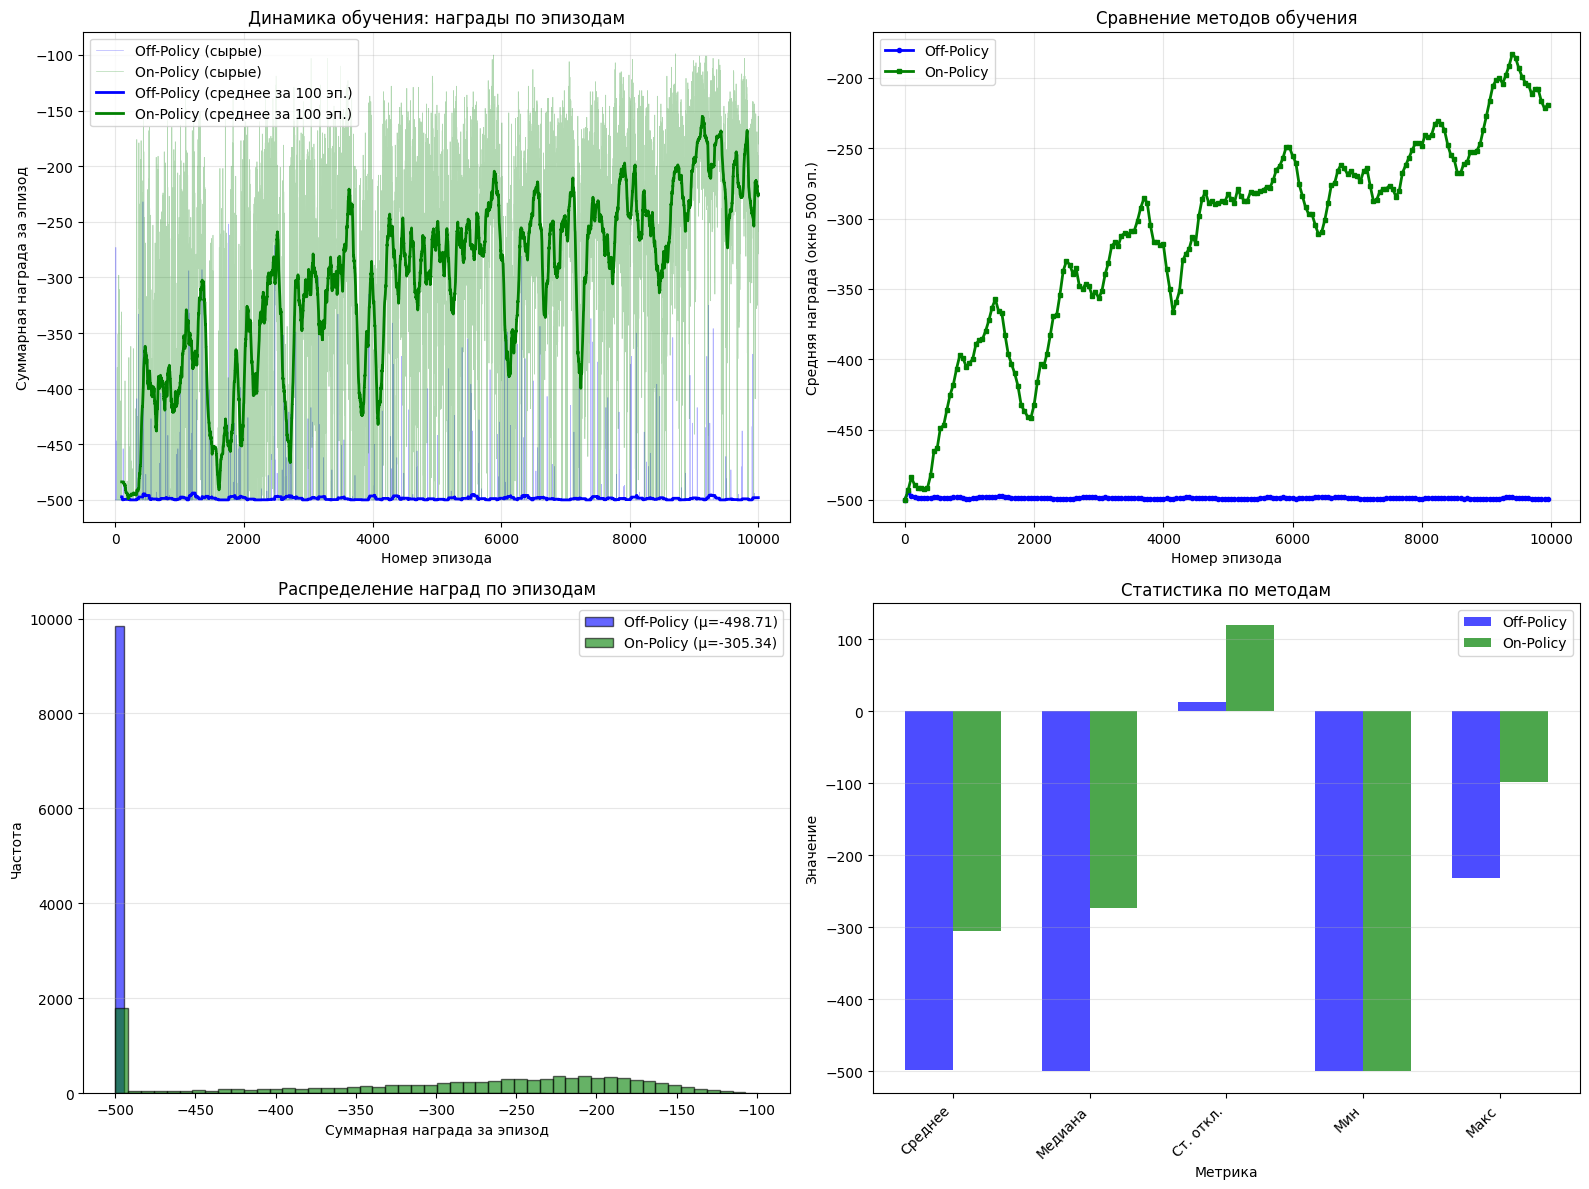


2. Статистика Q-функций:


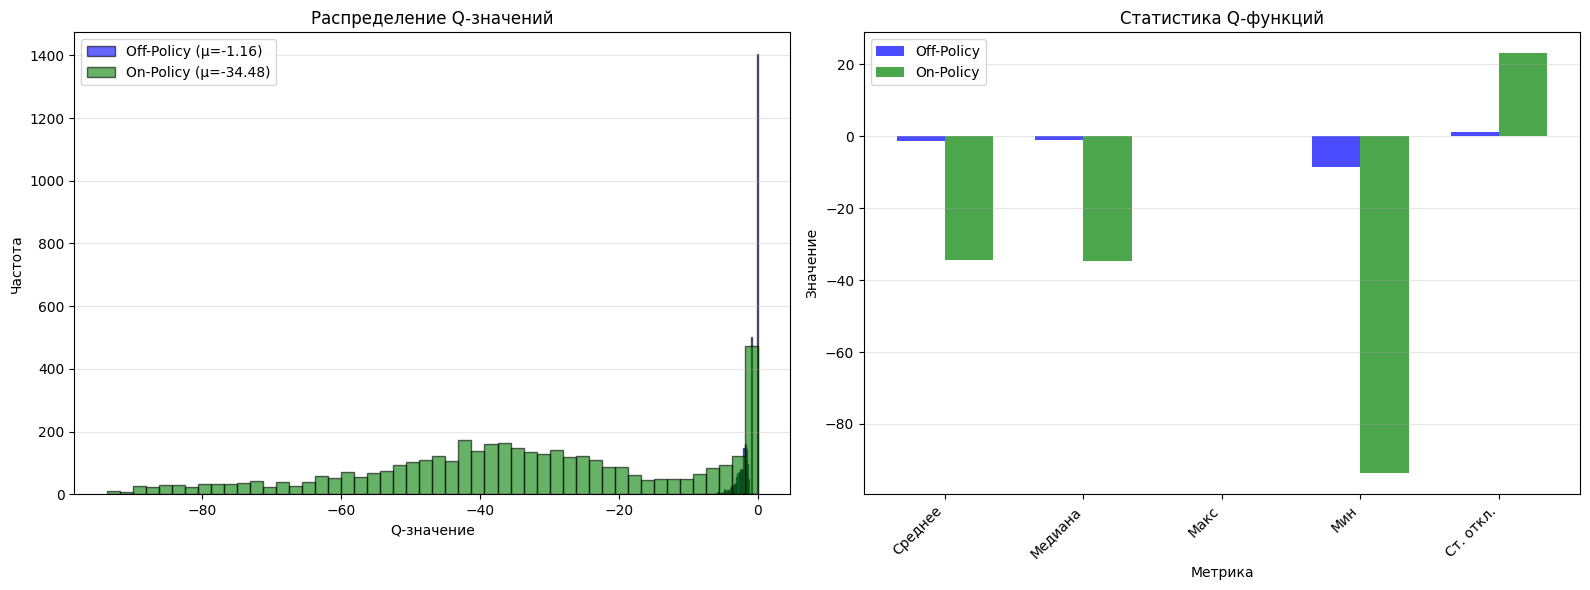

СТАТИСТИКА Q-ФУНКЦИЙ
Off-Policy:
  Количество состояний: 1070
  Среднее Q-значение: -1.1585
  Медиана Q-значения: -1.0000
  Максимальное Q-значение: 0.0000
  Минимальное Q-значение: -8.6452
  Стандартное отклонение: 1.3093

On-Policy:
  Количество состояний: 1400
  Среднее Q-значение: -34.4811
  Медиана Q-значения: -34.5494
  Максимальное Q-значение: 0.0000
  Минимальное Q-значение: -93.7554
  Стандартное отклонение: 23.0948

3. Сравнение стратегий:


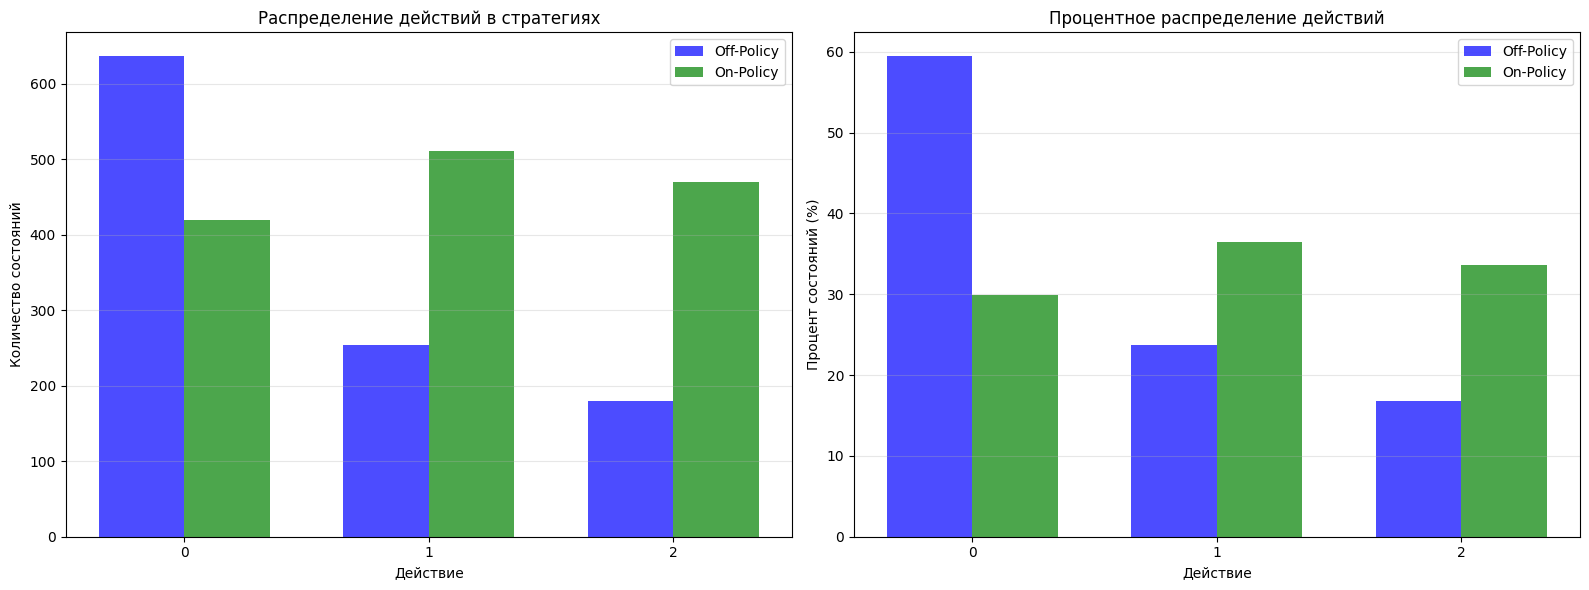

In [14]:
#@title Выполнение визуализации
print("=" * 60)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ")
print("=" * 60)

print("\n1. Кривые обучения и сравнение методов:")
plot_learning_curves(returns_off, returns_on)

print("\n2. Статистика Q-функций:")
plot_q_function_stats(Q_off, Q_on)

print("\n3. Сравнение стратегий:")
plot_policy_comparison(policy_off, policy_on)

# Выводы по проделанной работе:

В рамках данной работы мной была реализована система обучения с подкреплением для среды Acrobot с использованием методов Монте-Карло. Я использовал два подхода: off-policy метод с разделенной стратегией и on-policy метод с ε-жадной стратегией. Для работы с непрерывным пространством состояний мной была реализована функция дискретизации с использованием кэширования для оптимизации производительности.

При реализации off-policy метода я применил алгоритм Weighted Importance Sampling, который позволяет обучать целевую политику на данных, собранных поведенческой политикой. Мной была использована случайная поведенческая политика для сбора данных, что обеспечивает широкое исследование пространства состояний. Для целевой политики я реализовал детерминированно жадный выбор действий без использования epsilon-распада, что соответствует требованиям задания.

В on-policy методе мной была реализована ε-жадная стратегия с линейным затуханием epsilon от начального значения к финальному, что обеспечивает баланс между исследованием и эксплуатацией в процессе обучения. Для обновления Q-функции я использовал инкрементальное обновление с шагом обучения alpha, что позволяет постепенно улучшать оценки ценности действий.

Для улучшения качества обучения мной были оптимизированы параметры: коэффициент обесценивания gamma установлен в 0.99 для учета долгосрочных наград, количество эпизодов обучения составляет 10000 для достаточного сбора статистики. Я использовал библиотеку PyTorch для эффективных вычислений с тензорами и defaultdict для хранения Q-функции в разреженном формате.

По результатам экспериментов мной было установлено, что on-policy метод с ε-жадной стратегией показал значительно лучшие результаты (средняя награда -198.39) по сравнению с off-policy методом (средняя награда -497.00). Это объясняется тем, что on-policy метод обучается на данных, собранных той же политикой, что и целевая, что обеспечивает более стабильное обучение в данной среде. Off-policy метод, несмотря на теоретическую возможность обучения оптимальной политики, в данном случае показал худшие результаты из-за высокой дисперсии importance sampling весов при использовании случайной поведенческой политики.